# Критерий хи-квадрта

Импортируем необходимые библиотеки, читаем датафрейм - необходимые данные для поступления в университеты.

In [41]:
import pandas as pd
import numpy as np
import scipy.stats


df = pd.read_csv('adm_data.csv')
df.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


Добавим новую категориальную переменную - имеет ли университет наивысший рейтинг.

In [42]:
df['is_highest_uni_rating'] = pd.Categorical(df['University Rating'].apply(lambda v: v == 5))
df

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit,is_highest_uni_rating
0,1,337,118,4,4.5,4.5,9.65,1,0.92,False
1,2,324,107,4,4.0,4.5,8.87,1,0.76,False
2,3,316,104,3,3.0,3.5,8.00,1,0.72,False
3,4,322,110,3,3.5,2.5,8.67,1,0.80,False
4,5,314,103,2,2.0,3.0,8.21,0,0.65,False
...,...,...,...,...,...,...,...,...,...,...
395,396,324,110,3,3.5,3.5,9.04,1,0.82,False
396,397,325,107,3,3.0,3.5,9.11,1,0.84,False
397,398,330,116,4,5.0,4.5,9.45,1,0.91,False
398,399,312,103,3,3.5,4.0,8.78,0,0.67,False


Будем смотреть на две категориальные переменных: имеет ли университет наивысший рейтинг, требует ли университет иметь исследовательский опыт для поступления.

Нулевая гипотеза: распределение независимо по выбранным переменным.

In [43]:
ct_o = df.groupby('is_highest_uni_rating')['Research'].value_counts().unstack()
ct_o

Research,0,1
is_highest_uni_rating,,
False,173,167
True,8,52


Воспользуемся библиотекой `scipy` для нахождения хи-квадрат, в качестве аргумента передаем матрицу наблюдаемых частот (т.к. коррекция = 1, передаем в качестве аргумента ``correction=False``). Критическое значение = 6.63.

In [44]:
scipy.stats.chi2_contingency(ct_o, correction=False)

(29.024495087775016,
 7.146886347097846e-08,
 1,
 array([[153.85, 186.15],
        [ 27.15,  32.85]]))

Значение критерия `29.024495087775016` > критического значения `6.63`, следовательно, мы можем отвергнуть нулевую гипотезу, зависимость между категориями переменных скорее всего есть.

# t-тест

Рассмотрим две независимые выборки. 

Будем тестировать гипотезу, что существует разница между количеством `GRE Score`, которое требуется для поступления в университеты, требующие или не требующие наличие исследовательского опыта.

Нулевая гипотеза: средние для двух выборок равны.

In [45]:
research_required = df[df['Research'] == True]['GRE Score']
research_not_required = df[df['Research'] == False]['GRE Score']

Найдем t-критерий помощью функции из библиотеки `scipy.stats`.

In [46]:
t, p_value = scipy.stats.ttest_ind(research_not_required, research_required, equal_var=False)
t, p_value


(-14.369613919715873, 5.703850014733241e-38)

`pvalue` является очень маленьким - шанс получить ошибку 1-ого типа -> тест является статистически значимым.
Отвергаем Н0. Разница между средними статистически значима.

# Линейная регрессия

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import statsmodels.api as sm
import numpy as np

In [47]:
p = pd.concat([df['GRE Score'], df['LOR '], df['TOEFL Score'], df['SOP']], axis=1)
p.head()

,GRE Score,LOR,TOEFL Score,SOP
0,337,4.5,118,4.5
1,324,4.5,107,4.0
2,316,3.5,104,3.0
3,322,2.5,110,3.5
4,314,3.0,103,2.0


С помощью библиотеки `scipy` построим линейную модель с одним предиктором.

In [48]:
X = p['GRE Score']
y = p['TOEFL Score']

res = scipy.stats.linregress(X, y)
res

LinregressResult(slope=0.4422284488529551, intercept=-32.69128930998258, rvalue=0.8359768030143963, pvalue=9.011246680984254e-106, stderr=0.014551144249880318, intercept_stderr=4.612926341784913)

При одном шаге в изменении `GRE Score`, количество `TOEFL Score` изменяется на 0.45. `pvalue` (стат. значимость коэффициента) имеет низкое значение - связь статистически значима. 

Вычислим коэфф детерминации.

In [36]:
r_sq = res.rvalue ** 2
r_sq

0.6988572151781707

Коэффициент детерминации имеет достаточно высокое значение -> модель на 70% объясняет дисперсию целевой переменной.

Отобразим график рассеяния. 

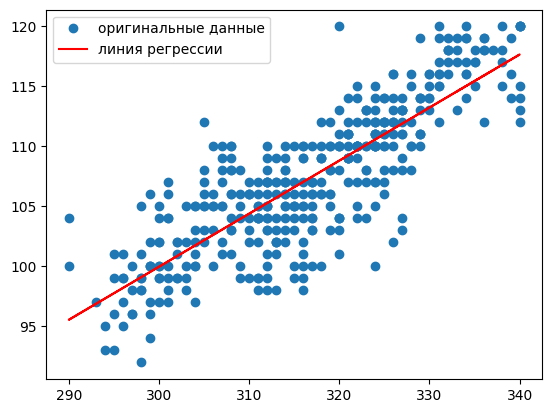

In [37]:
plt.plot(X, y, 'o', label='оригинальные данные')
plt.plot(X, res.intercept + res.slope*X, 'r', label='линия регрессии')
plt.legend()
plt.show()

Воспользуемся библиотекой `statsmodels` для построения уравнения линейной регрессии.
Сначала построим с одним предиктором, целевая переменная: `GRE Score`.

In [39]:
X_simple = p['GRE Score']
y = p['TOEFL Score']
X_simple_constant = sm.add_constant(X_simple)

mod = sm.OLS(y, X_simple_constant)
res_simple = mod.fit()
print(res_simple.summary())

                            OLS Regression Results                            
Dep. Variable:            TOEFL Score   R-squared:                       0.699
Model:                            OLS   Adj. R-squared:                  0.698
Method:                 Least Squares   F-statistic:                     923.6
Date:                Tue, 13 Dec 2022   Prob (F-statistic):          9.01e-106
Time:                        20:01:29   Log-Likelihood:                -1048.4
No. Observations:                 400   AIC:                             2101.
Df Residuals:                     398   BIC:                             2109.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -32.6913      4.613     -7.087      0.0

Коэффициент детерминации: 0.699, зависимость сильная. Оба коэфф стат значимы.

Построим линейную регрессию с несколькими предикторами.

In [49]:
X_mult = p.drop('TOEFL Score', axis=1)
y = p['TOEFL Score']
X_mult_constant = sm.add_constant(X_mult)

mod = sm.OLS(y, X_mult_constant)
res_mult = mod.fit()
print(res_mult.summary())

                            OLS Regression Results                            
Dep. Variable:            TOEFL Score   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                     362.6
Date:                Tue, 13 Dec 2022   Prob (F-statistic):          3.52e-113
Time:                        20:26:41   Log-Likelihood:                -1024.2
No. Observations:                 400   AIC:                             2056.
Df Residuals:                     396   BIC:                             2072.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -13.0408      5.176     -2.519      0.0

Коэфф детерминации вырос незначительно, введение новых переменных по сравнению с `GRE Score` незначительно улучшил модель. Коэфф `GRE Score `, `LOR` стат. значимы, положительные - чем выше значения, тем выше значение `TOEFL Score`.

# Логистическая регрессия


Вынесем количественные переменные в отдельную переменную `cols_num`.

In [172]:
cols_num = ['GRE Score', 'TOEFL Score', 'SOP', 'CGPA']

Построим модель логистической регрессии c одним предиктором с помощью библиотеки `statsmodels`.
В качестве предиктора будем использовать наличие или отсутствие требования исследовательского опыта, в качестве целевой переменной - имеет ли университет наивысший рейтинг.

In [189]:
X = df['Research']
y = df['is_highest_uni_rating']

X_constant = sm.add_constant(X)
logit = sm.Logit(y, X_constant).fit()
logit.summary()

Optimization terminated successfully.
         Current function value: 0.382025
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                             Logit Regression Results                            
=================================================================================
Dep. Variable:     is_highest_uni_rating   No. Observations:                  400
Model:                             Logit   Df Residuals:                      398
Method:                              MLE   Df Model:                            1
Date:                   Tue, 13 Dec 2022   Pseudo R-squ.:                 0.09625
Time:                           11:07:03   Log-Likelihood:                -152.81
converged:                          True   LL-Null:                       -169.08
Covariance Type:               nonrobust   LLR p-value:                 1.163e-08
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.0739      0.362     -8.500      0.000      -3.783      -2.365
Research       1.9071      0.395      4.829      0.000       1.133       2.681
==============================================================================
"""

полученные коэффициенты для интерпретации.

In [190]:
c1, c2 = np.exp(-3.0739), np.exp(1.9071)
c1, c2

(0.04624046492787434, 6.733533210323653)

Если предиктор = 0, то шанс события (университет требует наличие исследовательского опыта) = 0.05.

Построим логистическую регрессию для количественных переменных.

In [203]:
X = df[cols_num]
y = df['is_highest_uni_rating']

X_constant = sm.add_constant(X)
logit = sm.Logit(y, X_constant).fit()
logit.summary()

Optimization terminated successfully.
         Current function value: 0.248992
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                             Logit Regression Results                            
=================================================================================
Dep. Variable:     is_highest_uni_rating   No. Observations:                  400
Model:                             Logit   Df Residuals:                      395
Method:                              MLE   Df Model:                            4
Date:                   Tue, 13 Dec 2022   Pseudo R-squ.:                  0.4110
Time:                           12:34:18   Log-Likelihood:                -99.597
converged:                          True   LL-Null:                       -169.08
Covariance Type:               nonrobust   LLR p-value:                 4.681e-29
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         -26.2675      6.838     -3.841      0.000     -39.670     -12.865
GRE Score      -0.0159      0.039     -0.403      0.687      -0.093       0.061
TOEFL Score     0.0230      0.065      0.351      0.726      -0.105       0.151
SOP             1.4905      0.351      4.248      0.000       0.803       2.178
CGPA            2.3637      0.876      2.698      0.007       0.647       4.081
===============================================================================
"""

Центрирование. Сделаем интерпретацию относительно среднего значения переменной.

In [204]:
X = df[cols_num] - df[cols_num].mean()
y = df['is_highest_uni_rating']

X_constant = sm.add_constant(X)
logit = sm.Logit(y, X_constant).fit()
logit.summary()

Optimization terminated successfully.
         Current function value: 0.248992
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                             Logit Regression Results                            
=================================================================================
Dep. Variable:     is_highest_uni_rating   No. Observations:                  400
Model:                             Logit   Df Residuals:                      395
Method:                              MLE   Df Model:                            4
Date:                   Tue, 13 Dec 2022   Pseudo R-squ.:                  0.4110
Time:                           12:35:55   Log-Likelihood:                -99.597
converged:                          True   LL-Null:                       -169.08
Covariance Type:               nonrobust   LLR p-value:                 4.681e-29
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -3.4345      0.380     -9.034      0.000      -4.180      -2.689
GRE Score      -0.0159      0.039     -0.403      0.687      -0.093       0.061
TOEFL Score     0.0230      0.065      0.351      0.726      -0.105       0.151
SOP             1.4905      0.351      4.248      0.000       0.803       2.178
CGPA            2.3637      0.876      2.698      0.007       0.647       4.081
===============================================================================
"""

Стандартизация. Разделим на среднеквадратичное отклонение. Интерпретируется изменением на одно стандартное отклонение, а не изменением на одну единицу.

In [205]:
X = (df[cols_num] - df[cols_num].mean()) / df[cols_num].std()
y = df['is_highest_uni_rating']

X_constant = sm.add_constant(X)
logit = sm.Logit(y, X_constant).fit()
logit.summary()

Optimization terminated successfully.
         Current function value: 0.248992
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                             Logit Regression Results                            
=================================================================================
Dep. Variable:     is_highest_uni_rating   No. Observations:                  400
Model:                             Logit   Df Residuals:                      395
Method:                              MLE   Df Model:                            4
Date:                   Tue, 13 Dec 2022   Pseudo R-squ.:                  0.4110
Time:                           12:37:52   Log-Likelihood:                -99.597
converged:                          True   LL-Null:                       -169.08
Covariance Type:               nonrobust   LLR p-value:                 4.681e-29
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -3.4345      0.380     -9.034      0.000      -4.180      -2.689
GRE Score      -0.1821      0.451     -0.403      0.687      -1.067       0.703
TOEFL Score     0.1394      0.397      0.351      0.726      -0.639       0.918
SOP             1.5008      0.353      4.248      0.000       0.808       2.193
CGPA            1.4095      0.522      2.698      0.007       0.386       2.433
===============================================================================
"""